Download historical data from EIA and NOAA/GHCN-d to the local filesystem

In [1]:
import download_historical_data as dl
import os 

HISTORICAL_DATA_DIR = os.path.abspath("./historical_data")
ELECTRIC_DATA_DIR = os.path.join(HISTORICAL_DATA_DIR, "electric_data")
WEATHER_DATA_DIR = os.path.join(HISTORICAL_DATA_DIR, "weather_station_data")
WEATHER_STATION_IDS = [
    "USW00023066",  # Grand Junction Walker Field
    "USC00053553",  # Greeley UNC
    "USC00053005",  # Ft Collins
    "USC00050848",  # Boulder
    "USC00055984",  # Northglenn
    "USC00058995",  # Wheat Ridge
    "USW00023061"  # Alamosa
]
dl.download_historical_data(ELECTRIC_DATA_DIR, WEATHER_DATA_DIR, WEATHER_STATION_IDS, eia_respondent="PSCO")

Writing EIA demand data to c:\Users\breis\projects\e-predict\historical_data\electric_data\PSCO.json...
Completed downloading EIA demand data
Finished downloading data


Parse station observations data 

In [4]:
import os
from ghcnd.station_observations import read_from_dly_file

station_data = [read_from_dly_file(os.path.join(WEATHER_DATA_DIR, f)) for f in os.listdir(WEATHER_DATA_DIR)]

first_station = station_data[0]
first_station_obs = first_station.observations[0]
print(f"{first_station.station_id}: {first_station_obs.date} tmax={first_station_obs.tmax} tmin={first_station_obs.tmin}")


USC00050848: 2015-01-01 tmax=0 tmin=-144


Import station observations data in Pandas DataFrame

In [5]:
import pandas as pd
from datetime import date

obs = station_data[0].observations

hist_temp_df = pd.DataFrame(obs)
hist_temp_df["date"] = pd.to_datetime(hist_temp_df["date"])
hist_temp_df = hist_temp_df.assign(day_of_year=lambda x: x["date"].dt.day_of_year)

hist_temp_df.set_index("date", inplace=True)

hist_temp_df = hist_temp_df.interpolate(method="time")

hist_temp_df = hist_temp_df.assign(
    tmax_decimal=lambda x: x["tmax"] / 10.0,
    tmin_decimal=lambda x: x["tmin"] / 10.0)

Plot temp min/max

<AxesSubplot: xlabel='date'>

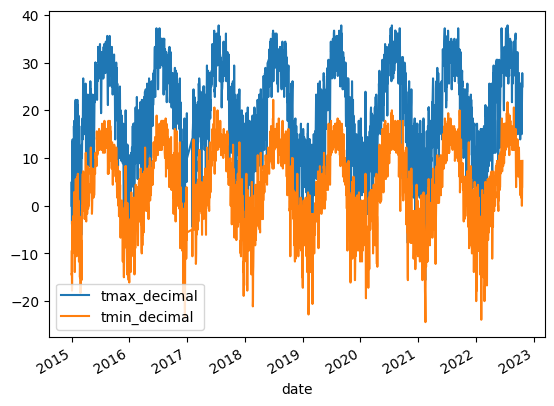

In [6]:
import matplotlib as plt

hist_temp_df.plot(y=["tmax_decimal", "tmin_decimal"])

Load electric demand data

             demand
count  64093.000000
mean    5241.897477
std      982.633679
min        0.000000
25%     4600.000000
50%     5098.000000
75%     5715.000000
max    60576.000000


<AxesSubplot: xlabel='date'>

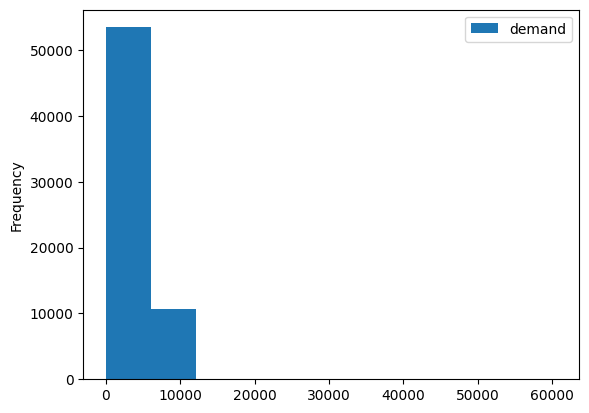

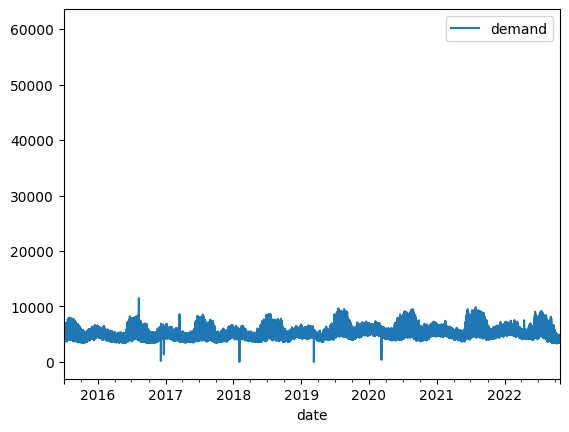

In [184]:
psco_demand_data_file = os.path.join(ELECTRIC_DATA_DIR, "psco.json")
demand_ds = pd.read_json(psco_demand_data_file, typ="frame", orient="records", convert_dates=["dates"])
demand_ds.set_index("date", inplace=True)
print(demand_ds.describe())
demand_ds.plot.hist()
demand_ds.plot()

Throw out some of the outliers and interpolate the now-missing values

inter-quartile range: 1115.0, median: 5098.0, valid data range: 1753.0 - 8443.0
             demand
count  64122.000000
mean    5236.942399
std      941.415947
min     3328.000000
25%     4600.000000
50%     5098.000000
75%     5715.000000
max     8441.000000


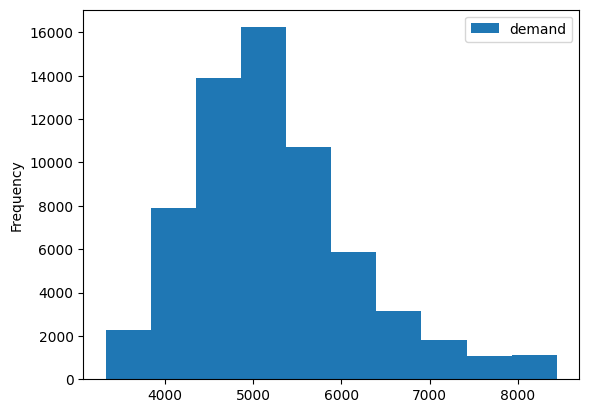

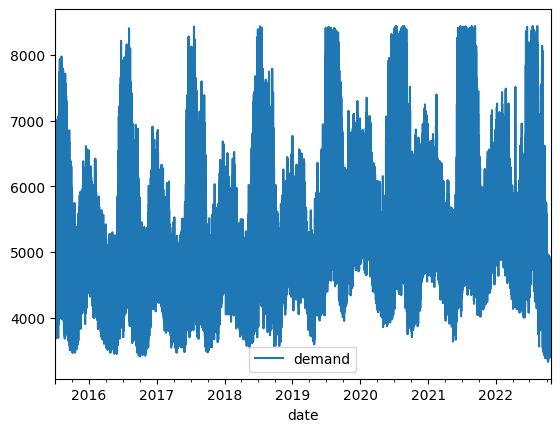

In [187]:
import numpy as np

## calculate inter-quartile range
iqr = demand_ds.quantile(0.75, numeric_only=False) - demand_ds.quantile(0.25, numeric_only=False)

## Find values within `iqr_mult` multiples of the median
iqr_mult = 3
median = demand_ds.median()
min_demand = median - (iqr * iqr_mult)
max_demand = median + (iqr * iqr_mult)
print(f"inter-quartile range: {iqr['demand']}, median: {median['demand']}, valid data range: {min_demand['demand']} - {max_demand['demand']}")

valid_rows = np.abs((demand_ds - median) / iqr) < iqr_mult
invalid_rows = valid_rows.loc[valid_rows["demand"] == False]

#print(demand_ds.loc[invalid_rows.index].head())

# replace outliers with nan
trimmed_ds = demand_ds.where(valid_rows, np.nan)
trimmed_ds.interpolate(inplace=True)

print(trimmed_ds.describe())
trimmed_ds.plot.hist()
trimmed_ds.plot()

demand_ds = trimmed_ds